In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # Only on works on Google Colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    # Configure kaggle if necessary
    if not (Path.home() / '.kaggle').is_dir():
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)
    
    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    
    os.chdir('MonkeyPFCSaccadeStudies')
        
    !pip install -q kaggle
    
    # Latest version of SKLearn
    !pip install -U scikit-learn
    
    IN_COLAB = True
    
except ModuleNotFoundError:
    import sys
    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
        
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA
from indl.display import turbo_cmap

In [4]:
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


In [6]:
from misc.misc import load_macaque_pfc, sess_infos, dec_from_enc

load_kwargs = {
    'x_chunk': 'spikerates',
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'verbose': True,
    'min_block_length': 10
}

test_sess_ix = 2

In [7]:
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nProcessing session {sess_id}")
X, Y, ax_info = load_macaque_pfc(data_path, sess_id, y_type='encoded input', **load_kwargs)
decis = dec_from_enc(Y)


Processing session sra3_1_j_050_00+
Found 285 trials, 207 timestamps(-0.25 to 1.81 at 100.0 Hz), 32 channels
Returning Y as encoded input with shape (285, 207, 11).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


### Loading the Data and Generating an Input Based on Task information

In [ ]:
cueColor = ax_info['instance_data'][['CueColour']].to_numpy()

tmp2 = ax_info['instance_data']
df = tmp2.drop(tmp2.index[indx])
block_indx = np.unique(df[['Block']].to_numpy(), return_index = True)[1]
block_indx = np.append(block_indx, X.shape[0])
cueColor = np.delete(cueColor, indx, axis=0)
y_true = y
 

# Free memory
del tmp
del indx
del block_length
del tmp2

encoded_in = np.zeros((X.shape[0], X.shape[1], 10))

for i in range(X.shape[0]):
    encoded_in[i, 50:, y[i]%4] = 1
    if cueColor[i] == 'r':
        encoded_in[i, 72:144, 4] = 1
    elif cueColor[i] == 'g':
        encoded_in[i, 72:144, 5] = 1
    else:
        encoded_in[i, 72:144, 6] = 1


block = 1
i = 0
while i < X.shape[0] and block < 7:
    if y[i]==0 or y[i]==1 or y[i]==2 or y[i]==7:
        if cueColor[i] == 'r':
            encoded_in[block_indx[block-1]:block_indx[block], :, 7] = 1
        elif cueColor[i] == 'g':
            encoded_in[block_indx[block-1]:block_indx[block], :, 8] = 1
        else:
            encoded_in[block_indx[block-1]:block_indx[block], :, 9] = 1
        i = block_indx[block]
        block = block + 1    
    else:
        i = i+1
    
y2 = np.zeros((y.shape[0], X.shape[1]))
for i in range(y.shape[0]):
    y2[i, :] = y[i]

In [0]:
SESS_ID = ['sra3_1_j_050_00', 'sra3_1_m_074_0001']
BATCH_SIZE = 16
P_TRAIN = 0.8
P_DROPOUT = 0.5      # Proportion of units to set to 0 on each step.
N_RNN_UNITS = 200      # Size of RNN output (state)
L2_REG = 1.7e-4       # Parameter regularization strength.
STATEFUL = False      # Whether or not to keep state between sequences (True is not tested)
EPOCHS = 5          # Number of loops through the entire data set.
EPOCHS2 = 15
BIN_DURATION = 25     # Width of window used to bin spikes, in 10 ms
BIN_OVRLP = 4
N_TAPS = 8
IMG_SIZE = 160            # Number of bins of history used in a sequence.
NCOMPONENTS = 8  # Number of components for CCA decomposition

In [8]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_in, y2, train_size=P_TRAIN)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train = ds_train.shuffle(int(encoded_in.shape[0] * P_TRAIN) + 1)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal


# Encoded Input to 8 Classes

### Decrease Sampling Rate

In [16]:
X = np.zeros((encoded_in.shape[0], N_TAPS, encoded_in.shape[2]))
X1 = np.zeros((X2.shape[0], N_TAPS, X2.shape[2]))  #downsampled neural activity
Y = np.zeros((encoded_in.shape[0], 8))
for j in range(N_TAPS-1):
    X[:, j, :] = np.mean(encoded_in[:, j*(BIN_DURATION - BIN_OVRLP):j*(BIN_DURATION - BIN_OVRLP) + BIN_DURATION, :], axis=1)  # Downsampled Encoded Input
    X1[:, j, :] = np.mean(X2[:, j*(BIN_DURATION - BIN_OVRLP):j*(BIN_DURATION - BIN_OVRLP) + BIN_DURATION, :], axis=1)  # Downsampled Spike Rates

X[:, N_TAPS-1, :] = np.mean(encoded_in[:, (N_TAPS-1)*(BIN_DURATION - BIN_OVRLP):, :], axis=1)
X1[:, N_TAPS-1, :] = np.mean(X2[:, (N_TAPS-1)*(BIN_DURATION - BIN_OVRLP):, :], axis=1)

for i in range(encoded_in.shape[0]):
    Y[i, y[i]] = 1


X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, train_size=P_TRAIN)

ds_train1 = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid1 = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train1 = ds_train1.shuffle(int(X.shape[0] * P_TRAIN) + 1)
ds_train1 = ds_train1.batch(BATCH_SIZE, drop_remainder=True)
ds_valid1 = ds_valid1.batch(BATCH_SIZE, drop_remainder=True)

  
print(ds_train)

<BatchDataset shapes: ((16, 166, 10), (16, 166)), types: (tf.float64, tf.float64)>


In [17]:
tf.keras.backend.clear_session()
input_shape = X.shape[1:]
output_shape = 8

inputs = tf.keras.layers.Input(shape = input_shape)
o1 = tf.keras.layers.SimpleRNN(300, activation='tanh', use_bias=True,
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros', kernel_regularizer=None,
                            recurrent_regularizer=None, bias_regularizer=None,
                            activity_regularizer=None, kernel_constraint=None,
                            recurrent_constraint=None, bias_constraint=None,
                            dropout=0.0, recurrent_dropout=0.0,
                            return_sequences=True, return_state=False,
                            go_backwards=False, stateful=False, unroll=False, name='rnn1')(inputs)
o2 = tf.keras.layers.Dense(32, name='dense1', activation='linear')(o1)
o3 = tf.keras.layers.LSTM(100, activation='tanh',dropout = P_DROPOUT,
                          recurrent_dropout = 0,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                          recurrent_regularizer=tf.keras.regularizers.l2(L2_REG),
                          return_sequences=True, stateful=False, name='rnn2')(o2)
o4 = tf.keras.layers.Dense(32, activation='linear', name='dense2')(o3)
o5 = tf.keras.layers.GlobalAveragePooling1D(name='average')(o4)
o6 = tf.keras.layers.Dropout(P_DROPOUT)(o5)
outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(o6)

model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 10)]           0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, 8, 300)            93300     
_________________________________________________________________
dense1 (Dense)               (None, 8, 32)             9632      
_________________________________________________________________
rnn2 (LSTM)                  (None, 8, 100)            53200     
_________________________________________________________________
dense2 (Dense)               (None, 8, 32)             3232      
_________________________________________________________________
average (GlobalAveragePoolin (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0     

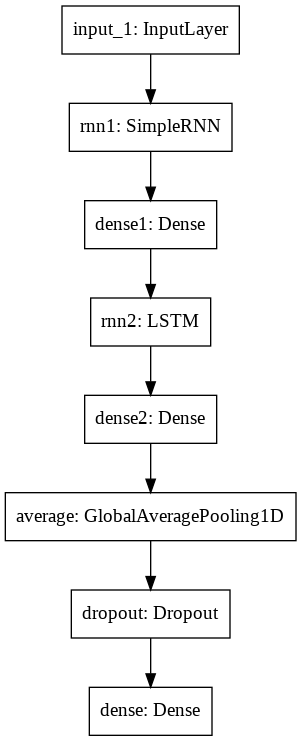

In [18]:
tf.keras.utils.plot_model(
    model1,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [19]:
# MONKEY J MODEL FIT
history = model1.fit(x=ds_train1, epochs=EPOCHS2, verbose=1, validation_data=ds_valid1)

Epoch 1/15
50/50 [==============================] - 4s 76ms/step - loss: 1.3432 - accuracy: 0.4825 - val_loss: 0.6898 - val_accuracy: 0.6667
Epoch 2/15
50/50 [==============================] - 2s 31ms/step - loss: 0.5275 - accuracy: 0.8263 - val_loss: 0.1522 - val_accuracy: 0.9688
Epoch 3/15
50/50 [==============================] - 1s 30ms/step - loss: 0.2508 - accuracy: 0.9588 - val_loss: 0.0964 - val_accuracy: 0.9688
Epoch 4/15
50/50 [==============================] - 2s 30ms/step - loss: 0.1660 - accuracy: 0.9613 - val_loss: 0.0919 - val_accuracy: 0.9688
Epoch 5/15
50/50 [==============================] - 2s 30ms/step - loss: 0.1416 - accuracy: 0.9650 - val_loss: 0.0737 - val_accuracy: 0.9688
Epoch 6/15
50/50 [==============================] - 1s 29ms/step - loss: 0.1223 - accuracy: 0.9625 - val_loss: 0.0688 - val_accuracy: 0.9688
Epoch 7/15
50/50 [==============================] - 2s 30ms/step - loss: 0.1242 - accuracy: 0.9613 - val_loss: 0.0769 - val_accuracy: 0.9688
Epoch 8/15
50

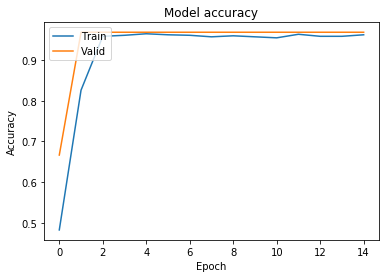

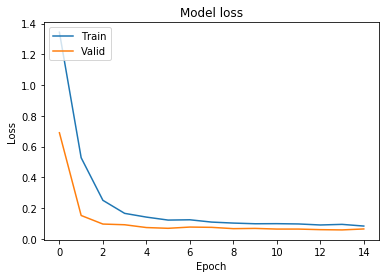

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Neural Activity to 8 Targets

In [0]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X1, y, train_size=P_TRAIN)

ds_trainN = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_validN = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_trainN = ds_trainN.shuffle(int(X.shape[0] * P_TRAIN) + 1)
ds_trainN = ds_trainN.batch(BATCH_SIZE, drop_remainder=True)
ds_validN = ds_validN.batch(BATCH_SIZE, drop_remainder=True)

In [22]:
tf.keras.backend.clear_session()
input_shape = X1.shape[1:]
output_shape = 8

inputs = tf.keras.layers.Input(shape = input_shape)
o1 = tf.keras.layers.SimpleRNN(200, activation='tanh', use_bias=True,
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros', kernel_regularizer=None,
                            recurrent_regularizer=None, bias_regularizer=None,
                            activity_regularizer=None, kernel_constraint=None,
                            recurrent_constraint=None, bias_constraint=None,
                            dropout=0.0, recurrent_dropout=0.0,
                            return_sequences=True, return_state=False,
                            go_backwards=False, stateful=False, unroll=False, name='rnn1')(inputs)
o2 = tf.keras.layers.Dense(150, name='dense1', activation='linear')(o1)
o3 = tf.keras.layers.LSTM(100,dropout = P_DROPOUT,
                          recurrent_dropout = 0,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                          recurrent_regularizer=tf.keras.regularizers.l2(L2_REG),
                          return_sequences=False, stateful=False, name='rnn2')(o2)
o6 = tf.keras.layers.Dropout(P_DROPOUT)(o3)
outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(o6)

modelN = tf.keras.Model(inputs, outputs)
modelN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 32)]           0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, 8, 200)            46600     
_________________________________________________________________
dense1 (Dense)               (None, 8, 150)            30150     
_________________________________________________________________
rnn2 (LSTM)                  (None, 100)               100400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
Total params: 177,958
Trainable params: 177,958
Non-trainable params: 0
_______________________________________________________

In [23]:
# MONKEY J MODEL FIT
history = modelN.fit(x=ds_trainN, epochs=EPOCHS2, verbose=1, validation_data=ds_validN)

Epoch 1/15
50/50 [==============================] - 4s 73ms/step - loss: 1.1705 - accuracy: 0.5575 - val_loss: 0.6633 - val_accuracy: 0.7344
Epoch 2/15
50/50 [==============================] - 1s 29ms/step - loss: 0.6847 - accuracy: 0.6988 - val_loss: 0.4928 - val_accuracy: 0.7969
Epoch 3/15
50/50 [==============================] - 1s 29ms/step - loss: 0.5550 - accuracy: 0.7875 - val_loss: 0.4490 - val_accuracy: 0.8438
Epoch 4/15
50/50 [==============================] - 1s 28ms/step - loss: 0.4773 - accuracy: 0.8150 - val_loss: 0.4973 - val_accuracy: 0.7917
Epoch 5/15
50/50 [==============================] - 1s 29ms/step - loss: 0.4229 - accuracy: 0.8413 - val_loss: 0.4824 - val_accuracy: 0.8177
Epoch 6/15
50/50 [==============================] - 1s 29ms/step - loss: 0.3573 - accuracy: 0.8800 - val_loss: 0.4693 - val_accuracy: 0.8333
Epoch 7/15
50/50 [==============================] - 1s 28ms/step - loss: 0.2885 - accuracy: 0.9250 - val_loss: 0.5521 - val_accuracy: 0.8229
Epoch 8/15
50

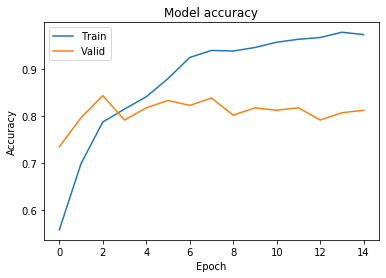

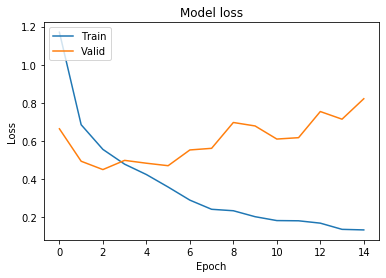

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## Some Shallow Learning to Compare

In [25]:
enc_in = np.reshape(encoded_in, (encoded_in.shape[0], encoded_in.shape[1] * encoded_in.shape[2]))
yy = np.reshape(y, (y.shape[0],))
x_tr, x_ts, y_tr, y_ts = train_test_split(enc_in, yy, train_size=P_TRAIN)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
lda = LinearDiscriminantAnalysis()
lda.fit(x_tr, y_tr)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(x_tr, y_tr)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(x_ts, y_ts)))

print('\n')
knn = KNeighborsClassifier()
knn.fit(x_tr, y_tr)
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(x_ts, y_ts)))
print('\n')
svm = SVC()
svm.fit(x_tr, y_tr)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(x_tr, y_tr)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(x_ts, y_ts)))

print('\n\n')

Accuracy of LDA classifier on training set: 0.67
Accuracy of LDA classifier on test set: 0.71


Accuracy of K-NN classifier on test set: 0.97


Accuracy of SVM classifier on training set: 0.96
Accuracy of SVM classifier on test set: 0.99





# Encoded Input to Final Gaze Position

In [0]:
gaze = df[['PosX', 'PosY']].to_numpy()
X_train, X_valid, Y_train, Y_valid = train_test_split(X, gaze, train_size=P_TRAIN)

ds_train2 = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid2 = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train2 = ds_train2.shuffle(int(X.shape[0] * P_TRAIN) + 1)
ds_train2 = ds_train2.batch(BATCH_SIZE, drop_remainder=True)
ds_valid2 = ds_valid2.batch(BATCH_SIZE, drop_remainder=True)

In [27]:
tf.keras.backend.clear_session()
input_shape = X.shape[1:]
output_shape = gaze.shape[1]

inputs = tf.keras.layers.Input(shape = input_shape)
o1 = tf.keras.layers.SimpleRNN(N_RNN_UNITS, activation='tanh', use_bias=True,
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros', kernel_regularizer=None,
                            recurrent_regularizer=None, bias_regularizer=None,
                            activity_regularizer=None, kernel_constraint=None,
                            recurrent_constraint=None, bias_constraint=None,
                            dropout=0.0, recurrent_dropout=0.0,
                            return_sequences=True, return_state=False,
                            go_backwards=False, stateful=False, unroll=False, name='rnn1')(inputs)
o2 = tf.keras.layers.Dense(32, name='dense1')(o1)
o3 = tf.keras.layers.LSTM(100, dropout = P_DROPOUT,
                          recurrent_dropout = 0,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                          recurrent_regularizer=tf.keras.regularizers.l2(L2_REG),
                          return_sequences=True, stateful=False, name='rnn2')(o2)
o4 = tf.keras.layers.Dense(32, name='dense2')(o3)
o5 = tf.keras.layers.AveragePooling1D(pool_size=8)(o4)
o6 = tf.keras.layers.Flatten()(o5)
o7 = tf.keras.layers.Dropout(P_DROPOUT)(o6)
outputs = tf.keras.layers.Dense(output_shape, activation='linear')(o7)

model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 10)]           0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, 8, 200)            42200     
_________________________________________________________________
dense1 (Dense)               (None, 8, 32)             6432      
_________________________________________________________________
rnn2 (LSTM)                  (None, 8, 100)            53200     
_________________________________________________________________
dense2 (Dense)               (None, 8, 32)             3232      
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0     

In [28]:
history = model2.fit(x=ds_train2, epochs=EPOCHS2, verbose=1, validation_data=ds_valid2)

Epoch 1/15
50/50 [==============================] - 7s 149ms/step - loss: 78.2486 - accuracy: 0.5838 - val_loss: 60.8908 - val_accuracy: 0.6250
Epoch 2/15
50/50 [==============================] - 1s 29ms/step - loss: 39.0725 - accuracy: 0.7525 - val_loss: 18.6194 - val_accuracy: 0.8750
Epoch 3/15
50/50 [==============================] - 1s 30ms/step - loss: 18.6190 - accuracy: 0.8725 - val_loss: 10.5699 - val_accuracy: 0.9323
Epoch 4/15
50/50 [==============================] - 1s 29ms/step - loss: 14.3336 - accuracy: 0.8850 - val_loss: 11.6738 - val_accuracy: 0.9115
Epoch 5/15
50/50 [==============================] - 2s 31ms/step - loss: 15.4696 - accuracy: 0.8788 - val_loss: 9.3826 - val_accuracy: 0.8802
Epoch 6/15
50/50 [==============================] - 1s 29ms/step - loss: 13.8967 - accuracy: 0.8537 - val_loss: 6.8763 - val_accuracy: 0.9323
Epoch 7/15
50/50 [==============================] - 1s 30ms/step - loss: 13.4657 - accuracy: 0.8800 - val_loss: 6.8144 - val_accuracy: 0.9010
E

In [0]:
pred_y = model2.predict(x=X)

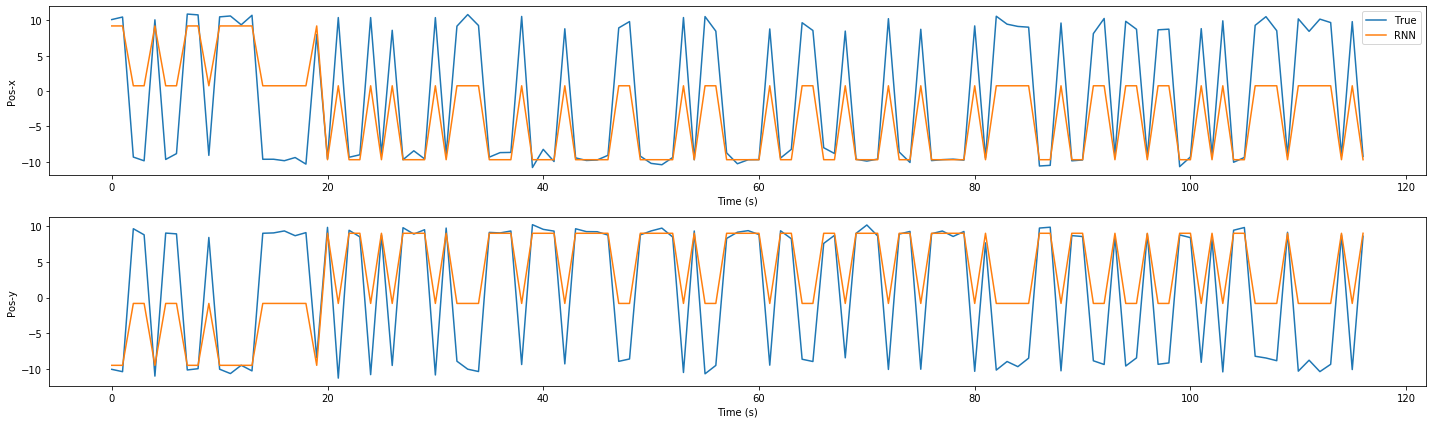

In [30]:
t = [900, 1017]

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)

plt.plot(gaze[t[0]:t[1], 0])
plt.plot(pred_y[t[0]:t[1], 0])
for ix, label in enumerate(['True', 'RNN']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Pos-x')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(gaze[t[0]:t[1], 1])
plt.plot(pred_y[t[0]:t[1], 1])
for ix, label in enumerate(['True', 'RNN']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Pos-y')

plt.tight_layout()
plt.show()

## Velocity

In [0]:
pred_vel = np.diff(pred_y, axis=0)
pred_vel /= np.linalg.norm(pred_vel)
gaze_vel = np.diff(gaze, axis=0)
gaze_vel /= np.linalg.norm(gaze_vel)

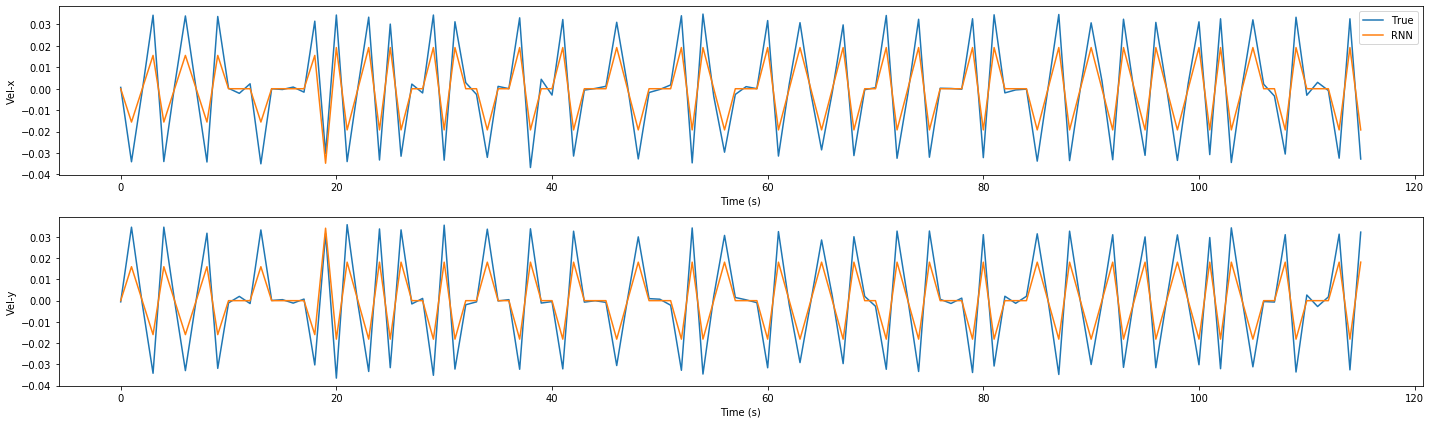

In [32]:
t = [900, 1017]

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)

plt.plot(gaze_vel[t[0]:t[1], 0])
plt.plot(pred_vel[t[0]:t[1], 0])
for ix, label in enumerate(['True', 'RNN']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Vel-x')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(gaze_vel[t[0]:t[1], 1])
plt.plot(pred_vel[t[0]:t[1], 1])
for ix, label in enumerate(['True', 'RNN']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Vel-y')

plt.tight_layout()
plt.show()

# Encoded Input to Continous Gaze

In [33]:
gaze_con, _, ax_info = load_macaque_pfc(datadir, SESS_ID[0], x_chunk='gaze', zscore=True)

# deleting blocks of gaze with less than 10 trials
tmp = np.unique(ax_info['instance_data'][['Block']].to_numpy(), return_index = True)[1]
block_length = np.diff(tmp)
indx = []
for i in range(len(tmp)-1):
  if block_length[i] < 10:
    indx = indx + list(range(tmp[i], tmp[i+1]))

gaze_con = np.delete(gaze_con, indx, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal


## Loading the Neural Data and Generating the Encoded Input Again for Assurance

In [34]:
X2, y, ax_info = load_macaque_pfc(datadir, SESS_ID[0], zscore=True)
cueColor = ax_info['instance_data'][['CueColour']].to_numpy()

# Deleting blocks with less than 10 trials
tmp = np.unique(ax_info['instance_data'][['Block']].to_numpy(), return_index = True)[1]
block_length = np.diff(tmp)
indx = []
for i in range(len(tmp)-1):
  if block_length[i] < 10:
    indx = indx + list(range(tmp[i], tmp[i+1]))

X2 = np.delete(X2, indx, axis=0)
y = np.delete(y, indx, axis=0)


# Making the encoded input again
tmp2 = ax_info['instance_data']
df = tmp2.drop(tmp2.index[indx])
block_indx = np.unique(df[['Block']].to_numpy(), return_index = True)[1]
block_indx = np.append(block_indx, X2.shape[0])
cueColor = np.delete(cueColor, indx, axis=0)
 

# Free memory
del tmp
del indx
del block_length
del tmp2

encoded_in = np.zeros((X2.shape[0], X2.shape[1], 10))

for i in range(X2.shape[0]):
  encoded_in[i, 50:, y[i]%4] = 1
  if cueColor[i] == 'r':
    encoded_in[i, 72:144, 4] = 1
  elif cueColor[i] == 'g':
    encoded_in[i, 72:144, 5] = 1
  else:
    encoded_in[i, 72:144, 6] = 1


block = 1
i = 0
while i < X2.shape[0] and block < 7:
  if y[i]==0 or y[i]==1 or y[i]==2 or y[i]==7:
    if cueColor[i] == 'r':
      encoded_in[block_indx[block-1]:block_indx[block], :, 7] = 1
    elif cueColor[i] == 'g':
      encoded_in[block_indx[block-1]:block_indx[block], :, 8] = 1
    else:
      encoded_in[block_indx[block-1]:block_indx[block], :, 9] = 1
    i = block_indx[block]
    block = block + 1    
  else:
    i = i+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal


In [0]:
X3 = np.zeros((gaze_con.shape[0], encoded_in.shape[1], gaze_con.shape[2]))

# downsampling continuous gaze to same as encoded input
X3[:, :-1, :] = gaze_con[:, ::10, :]
X3[:, -1, :] = gaze_con[:, -1, :]

X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_in, X3, train_size=P_TRAIN)

ds_train4 = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid4 = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train4 = ds_train4.shuffle(int(encoded_in.shape[0] * P_TRAIN) + 1)
ds_train4 = ds_train4.batch(BATCH_SIZE, drop_remainder=True)
ds_valid4 = ds_valid4.batch(BATCH_SIZE, drop_remainder=True)

In [36]:
tf.keras.backend.clear_session()
input_shape = encoded_in.shape[1:]
output_shape = X3.shape[2]

inputs = tf.keras.layers.Input(shape = input_shape)
o1 = tf.keras.layers.SimpleRNN(N_RNN_UNITS, activation='tanh', use_bias=True,
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros', kernel_regularizer=None,
                            recurrent_regularizer=None, bias_regularizer=None,
                            activity_regularizer=None, kernel_constraint=None,
                            recurrent_constraint=None, bias_constraint=None,
                            dropout=0.0, recurrent_dropout=0.0,
                            return_sequences=True, return_state=False,
                            go_backwards=False, stateful=False, unroll=False, name='rnn1')(inputs)
o2 = tf.keras.layers.Dense(32, name='dense1')(o1)
o3 = tf.keras.layers.LSTM(100, dropout = P_DROPOUT,
                          recurrent_dropout = 0,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                          recurrent_regularizer=tf.keras.regularizers.l2(L2_REG),
                          return_sequences=True, stateful=False, name='rnn2')(o2)
o4 = tf.keras.layers.Dense(32, name='dense2')(o3)
o5 = tf.keras.layers.Dropout(P_DROPOUT)(o4)
outputs = tf.keras.layers.Dense(output_shape, activation='linear')(o5)

model8 = tf.keras.Model(inputs, outputs)
model8.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model8.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 166, 10)]         0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, 166, 200)          42200     
_________________________________________________________________
dense1 (Dense)               (None, 166, 32)           6432      
_________________________________________________________________
rnn2 (LSTM)                  (None, 166, 100)          53200     
_________________________________________________________________
dense2 (Dense)               (None, 166, 32)           3232      
_________________________________________________________________
dropout (Dropout)            (None, 166, 32)           0         
_________________________________________________________________
dense (Dense)                (None, 166, 2)            66    

In [37]:
history = model8.fit(x=ds_train4, epochs=EPOCHS2, verbose=1, validation_data=ds_valid4)

Epoch 1/15
50/50 [==============================] - 46s 925ms/step - loss: 0.6610 - accuracy: 0.7519 - val_loss: 0.5659 - val_accuracy: 0.7560
Epoch 2/15
50/50 [==============================] - 44s 870ms/step - loss: 0.6037 - accuracy: 0.7814 - val_loss: 0.5522 - val_accuracy: 0.7645
Epoch 3/15
50/50 [==============================] - 43s 862ms/step - loss: 0.5833 - accuracy: 0.7847 - val_loss: 0.5395 - val_accuracy: 0.7653
Epoch 4/15
50/50 [==============================] - 43s 869ms/step - loss: 0.5764 - accuracy: 0.7863 - val_loss: 0.5357 - val_accuracy: 0.7652
Epoch 5/15
50/50 [==============================] - 43s 867ms/step - loss: 0.5669 - accuracy: 0.7862 - val_loss: 0.5252 - val_accuracy: 0.7641
Epoch 6/15
50/50 [==============================] - 43s 857ms/step - loss: 0.5614 - accuracy: 0.7867 - val_loss: 0.5320 - val_accuracy: 0.7670
Epoch 7/15
50/50 [==============================] - 43s 861ms/step - loss: 0.5554 - accuracy: 0.7884 - val_loss: 0.5257 - val_accuracy: 0.7652

In [0]:
predicted_gaze = model8.predict(encoded_in)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  if __name__ == '__main__':


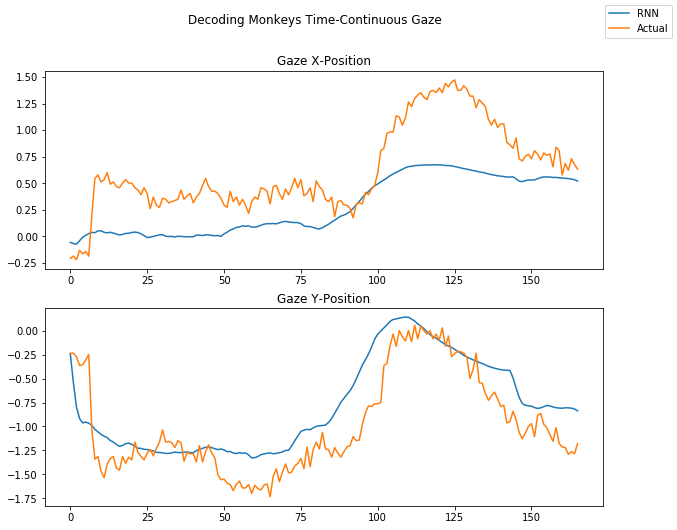

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(10,8))
fig.suptitle('Decoding Monkeys Time-Continuous Gaze')
axs[0].plot(predicted_gaze[20, :, 0], 'C0', label='RNN')
axs[0].plot(X3[20, :, 0], 'C1', label='Actual')
axs[0].set_title("Gaze X-Position")
axs[1].plot(predicted_gaze[20, :, 1], 'C0')
axs[1].plot(X3[20, :, 1], 'C1')
axs[1].set_title("Gaze Y-Position")
fig.legend(loc='best')

In [0]:
layer_name = 'dense1'
intermediate_layer_model1 = tf.keras.Model(inputs=model8.input,
                                 outputs=model8.get_layer(layer_name).output)
layer_name = 'dense2'
intermediate_layer_model2 = tf.keras.Model(inputs=model8.input,
                                 outputs=model8.get_layer(layer_name).output)
data = encoded_in
intermediate_output1 = intermediate_layer_model1.predict(data)
intermediate_output2 = intermediate_layer_model2.predict(data)

## CCA on RNN activations and Spikerates

In [0]:
A = np.mean(X2, axis=0) # Spikerates averaged over trials
B = np.mean(intermediate_output1, axis=0) # RNN activations averaged over trials
cca = CCA(n_components = NCOMPONENTS)

a_score, b_score = cca.fit_transform(A, B)

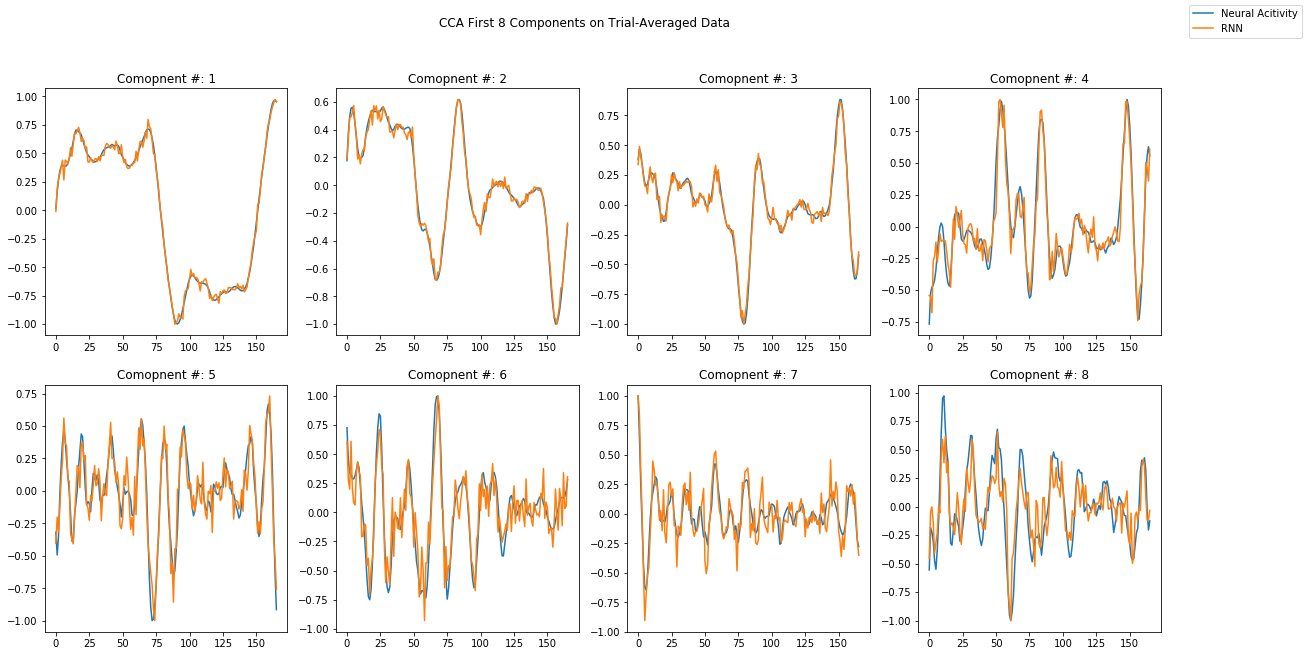

In [111]:
# Normalizing the components to plot with each other
a_score_norm = (a_score - np.mean(a_score, axis=0))/np.max(np.abs(a_score), axis=0)
b_score_norm = (b_score - np.mean(b_score, axis=0))/np.max(np.abs(b_score), axis=0)

COMPONENTSPLOT = 8  # To plot the first 'COMPONENTSPLOT'
fig, axs = plt.subplots(int(COMPONENTSPLOT/4), 4, figsize=(20,10))
fig.suptitle('CCA First 8 Components on Trial-Averaged Data')
for component in range(COMPONENTSPLOT):
  axs[int(component/4), component%4].plot(a_score_norm[:,component], 'C0')
  axs[int(component/4), component%4].plot(b_score_norm[:,component], 'C1')
  axs[int(component/4), component%4].set_title("Comopnent #: " + str(component+1))

fig.legend(('Neural Acitivity', 'RNN'))

In [112]:
from scipy.stats import pearsonr
from scipy.stats import linregress

corrcoef, p_value = pearsonr(a_score[:,0],b_score[:,0])
print("Pearson R correlation coefficient for the first component is: " + str(corrcoef))

slope, intercept, r_value, p_value, std_err = linregress(a_score[:,0],b_score[:,0])
print("\nScipy linear regression R2 value for the first component is: " + str(r_value**2))


# https://stackoverflow.com/questions/37398856/how-to-get-the-first-canonical-correlation-from-sklearns-cca-module
print("\nNumpy correlation coefficient for all components are: " + str(np.corrcoef(a_score.T, b_score.T).diagonal(offset=NCOMPONENTS)))

Pearson R correlation coefficient for the first component is: 0.9984061860935394

Scipy linear regression R2 value for the first component is: 0.9968149124298477

Numpy correlation coefficient for all components are: [0.99840619 0.99624105 0.99144424 0.95550045 0.92790375 0.9085314
 0.86276601 0.84790828]


### Reconstrocting maximum-correlated signals in original space 

In [0]:
neural_reconstructed = cca.inverse_transform(a_score_norm)
rnn_reconstructed = cca.inverse_transform(b_score_norm)

Plotting the reconstructed neural and RNN components

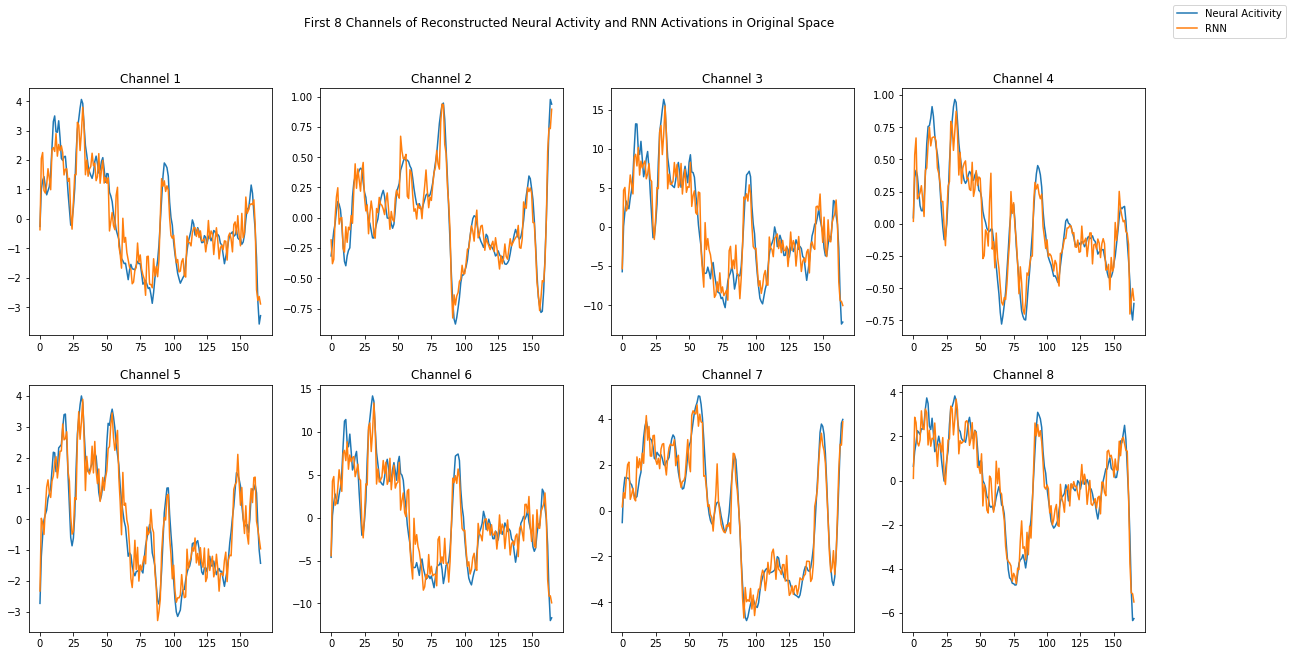

In [116]:
NCHANNELS = 8
fig, axs = plt.subplots(int(NCHANNELS/4), 4, figsize=(20,10))
fig.suptitle('First 8 Channels of Reconstructed Neural Activity and RNN Activations in Original Space')
for channel in range(NCHANNELS):
  axs[int(channel/4), channel%4].plot(neural_reconstructed[:,channel], 'C0')
  axs[int(channel/4), channel%4].plot(rnn_reconstructed[:,channel], 'C1')
  axs[int(channel/4), channel%4].set_title("Channel " + str(channel+1))

fig.legend(('Neural Acitivity', 'RNN'))

## Plotting the Original Spike Rates to Compare with The Reconstructed Components

### Sanity Check

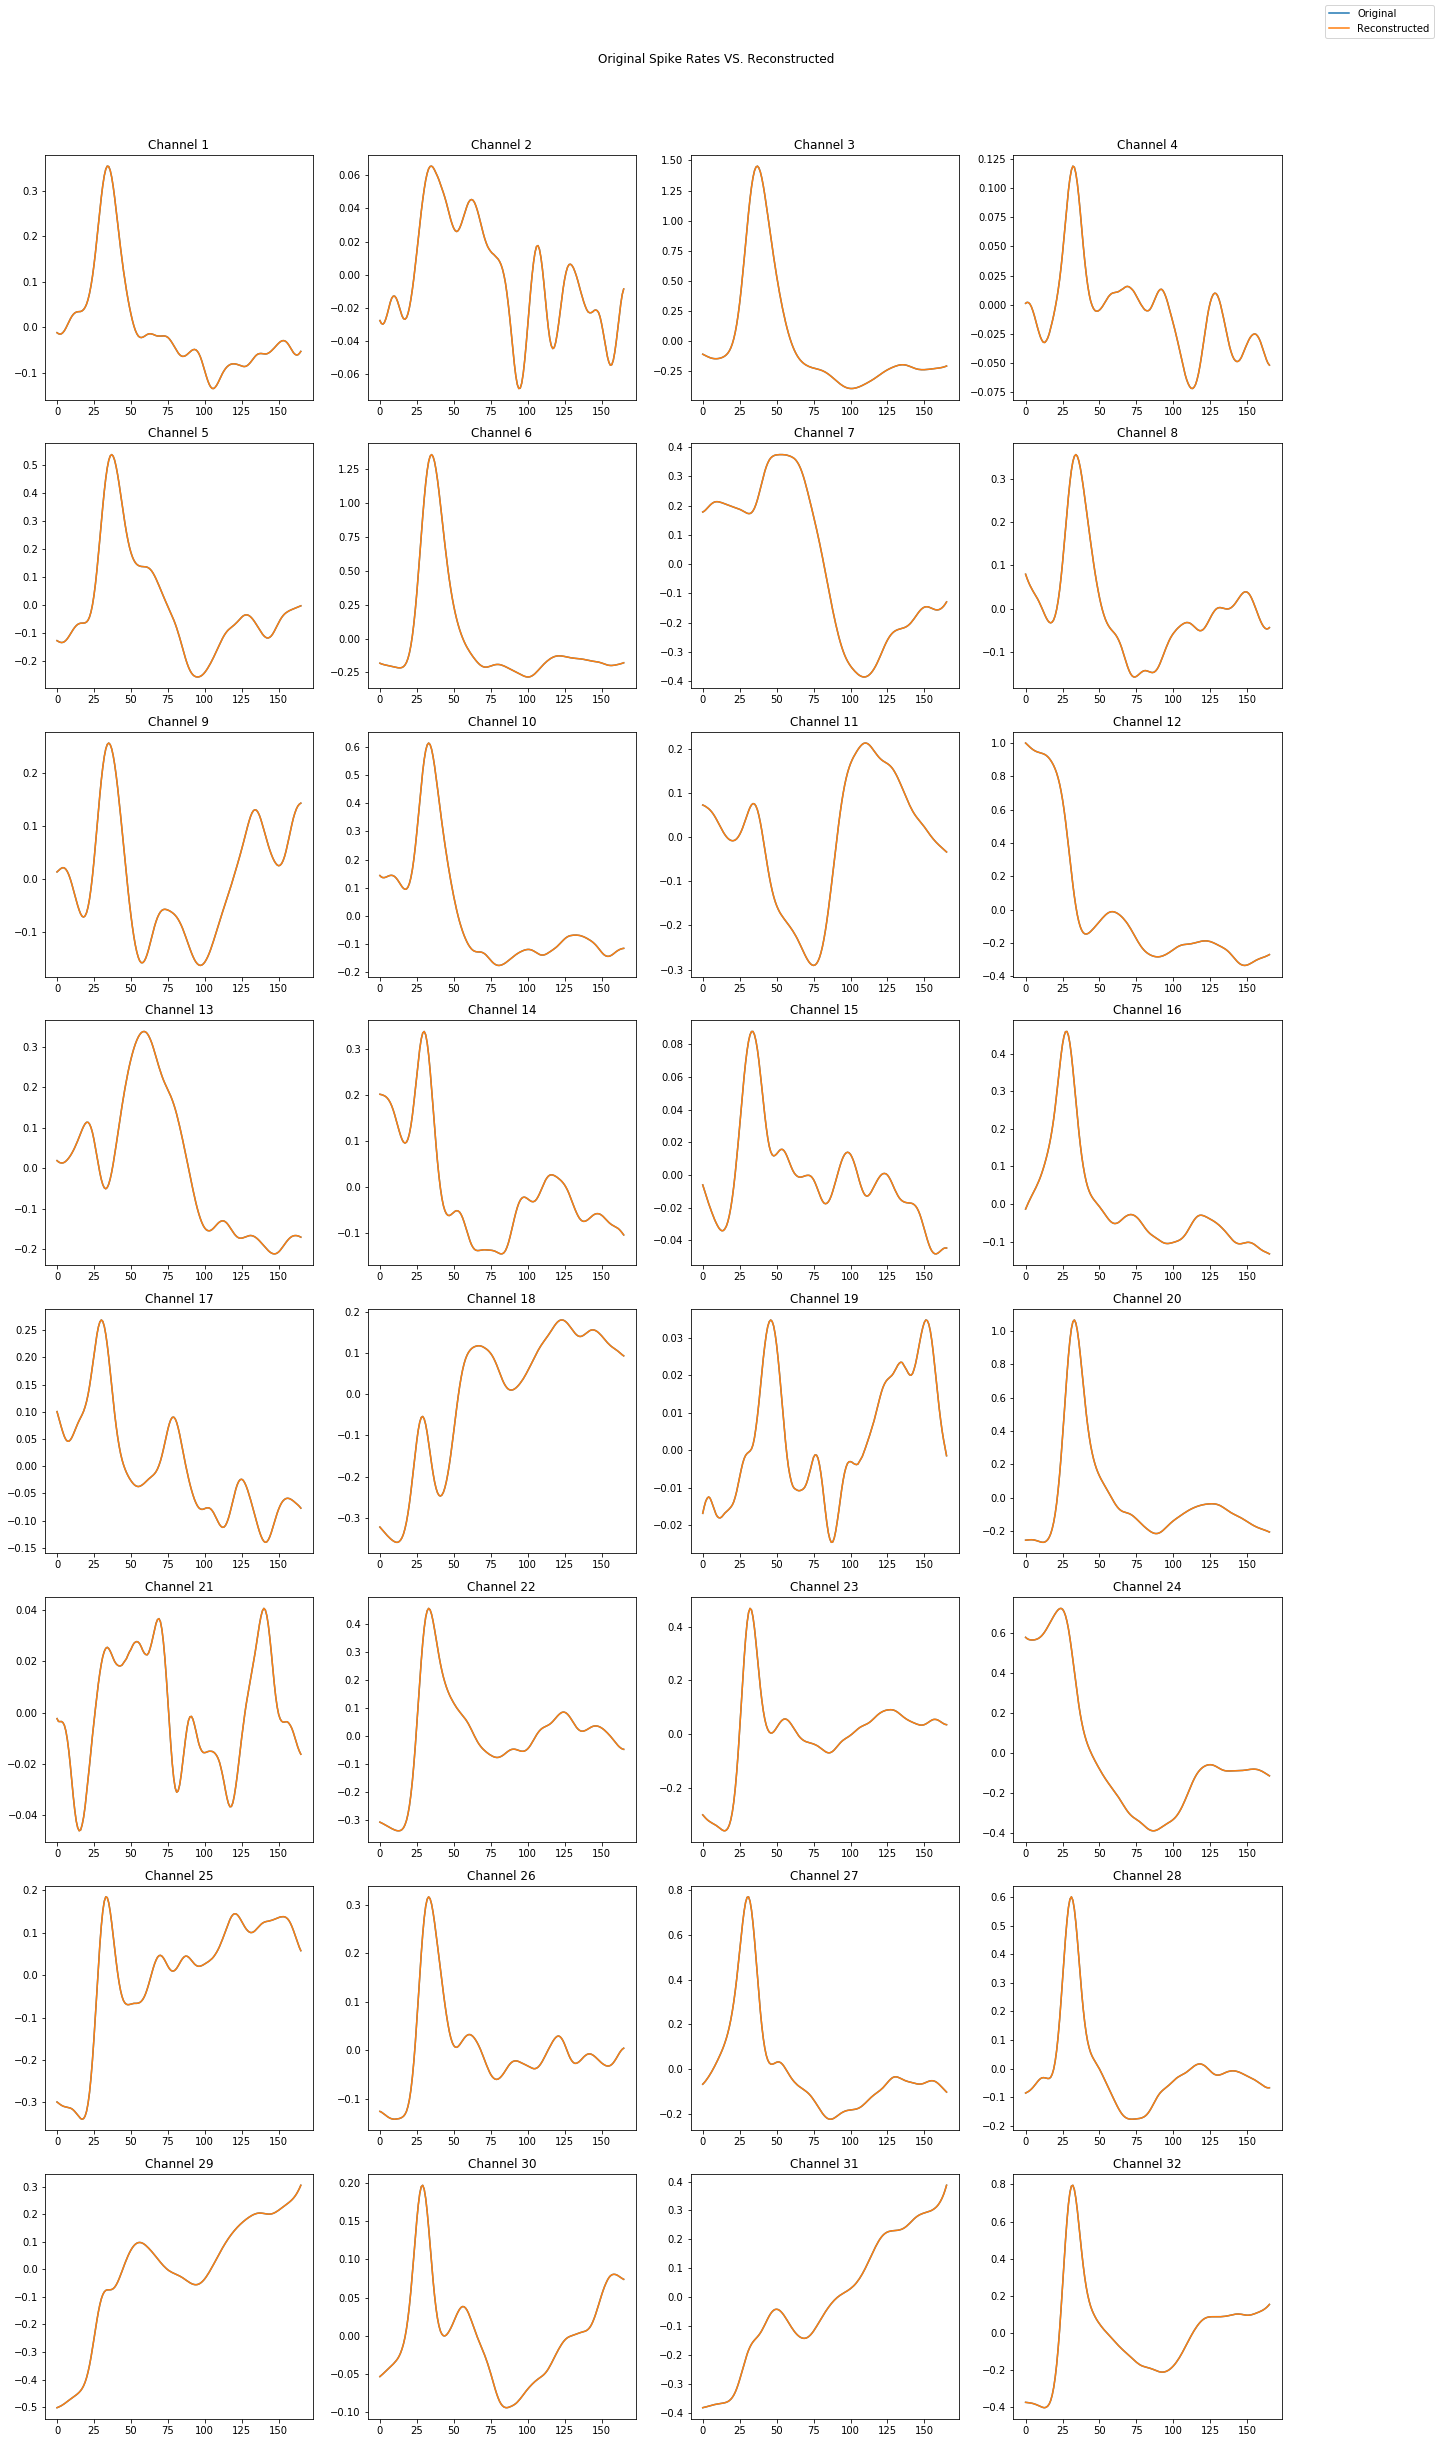

In [108]:
original = A
reconstructed = neural_reconstructed

NCHANNELS = 32
fig, axs = plt.subplots(int(NCHANNELS/4), 4, figsize=(20,35))
fig.suptitle('Original Spike Rates VS. Reconstructed')
for channel in range(NCHANNELS):
  axs[int(channel/4), channel%4].plot(original[:,channel], 'C0')
  axs[int(channel/4), channel%4].plot(reconstructed[:,channel], 'C1')
  axs[int(channel/4), channel%4].set_title("Channel " + str(channel+1))

fig.legend(('Original', 'Reconstructed'))
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])

IF we use NCOMPONENTS = 32, the reconstucted neural activity and the original spike rates will be exactly the same (As it should be).